# Tutorial on using FEniCSx for solving PDEs

This is the Google Colab notebook containing a tutorial on using the open source package [FEniCSx](https://fenicsproject.org/) for solving PDEs. This tutorial was prepared by [Andrej Košmrlj](https://www.princeton.edu/~akosmrlj/) with the help of Anvitha Sudhakar for the [DSOFT](https://engage.aps.org/dsoft/home) Short Course on [Computing Soft Matter Across Scales](https://meetings.aps.org/Meeting/MAR23/Session/2E) during the [APS March Meeting 2023](https://meetings.aps.org/Meeting/MAR23/Content/4348).

## Layout

This tutorial is organized as follows:

*   several examples of solving the Poisson's equation in 2d
*   one example of solving 2d linear elasticity problem
*   one example of solving the Cahn-Hilliard equation in 2d

## Additional resources

There is a very detailed [FEniCS tutorial eBook](https://fenicsproject.org/tutorial/). Please note that this eBook was written in 2017 and many of the functions have slightly changed during the transition from FEniCS to FEniCSx. Here are a few demos with explanations that are up to date:
* https://jsdokken.com/dolfinx-tutorial/
* https://docs.fenicsproject.org/dolfinx/v0.6.0/python/demos.html

## Installation

In order to run the examples below, we need to install the following software:

*   [FEniCSx](https://fenicsproject.org/) via the [FEM on Colab](https://fem-on-colab.github.io/)
*   [Gmsh](https://gmsh.info/) package for constructing meshes (also via the [FEM on Colab](https://fem-on-colab.github.io/))
*   [PyVista](https://docs.pyvista.org/) package for visualization

We also recommend installing [Paraview](https://www.paraview.org/) on a local disk for visualization.

Run the cell below to install the necessary packages. <font color='red'>Note that the run will likely crash during the first attempt. If this happens, then rerun the cell to complete the installation.</font>

In [1]:
!wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
!wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
!apt-get install -qq xvfb
!pip install pyvista panel -q

--2023-03-05 15:37:41--  https://fem-on-colab.github.io/releases/fenicsx-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4319 (4.2K) [application/x-sh]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[===================>]   4.22K  --.-KB/s    in 0s      

2023-03-05 15:37:41 (39.3 MB/s) - ‘/tmp/fenicsx-install.sh’ saved [4319/4319]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/3e737e4/releases/pybind1

# <a name="poissonBasic"></a>Basic Poisson equation

This example illustrates how to:

- Solve a linear partial differential equation;
- Create a mesh for a disk domain using Gmsh;
- Define a `FunctionSpace`;
- Create and apply Dirichlet boundary conditions;
- Plot the solution using PyVista;
- Compare results with the exact solution;
- Evaluate the value of the function at an arbitrary location.

## Equation and problem definition

The Poisson equation on a unit disk ($R=1$) with  Dirichlet boundary conditions:

<div align="center">    
    \begin{array}{r c c l}
    \nabla^2 u &=& -1 & \text{in } \Omega,\\
    u &=& 0 & \text{on } \Gamma.\\
    \end{array}    
</div>



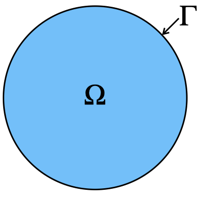

The exact solution in Cartesian coordinates is
$$u({\bf x})\equiv u(x,y)=\frac{1}{4} \left(1-x^2-y^2\right).$$

### Weak formulation of the problem

In FEniCS, we are solving the weak form of the PDE
$$\int_\Omega d{\bf x} \ (\nabla^2 u + 1) \ v = 0,$$
where $v$ is an arbitrary *test function* that evaluates to $0$ on the boundary points with prescribed values (Dirichlet boundary conditions). Using integration by parts, the above equation can be rewritten as 
$$\int_\Omega d{\bf x} \ (-\nabla u \cdot \nabla v + v) = 0.$$


## Implementation

In order to use the FEniCSx package we need to import the relevant libraries:

In [2]:
from dolfinx import *
import gmsh
from dolfinx.io import gmshio
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import *
import matplotlib.pyplot as plt
import numpy as np
import pyvista
pyvista.set_jupyter_backend("panel")
pyvista.start_xvfb()

Define a circular domain and generate a triangular mesh using [Gmsh](https://gmsh.info/). The cell size is set by the $meshSize$ variable.

In [3]:
# generate a unit disk mesh via Gmsh
gmsh.initialize()
R = 1. # radius
meshSize = 0.05 # cell size
gdim = 2 # dimensionality of the system
markerId = 1
disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()
gmsh.model.addPhysicalGroup(gdim, [disk], markerId)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",meshSize)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",meshSize)
gmsh.model.mesh.generate(gdim)
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)
gmsh.finalize()

#visualize the mesh using PyVista
tdim = domain.topology.dim
topology, cell_types, geometry = plot.create_vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter = pyvista.Plotter(notebook=True)
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, sizing_mode='stretch_width')

Next, we define the `FunctionSpace` that lives on the mesh.

In [4]:
#define function space
degreeElements = 1
FS = fem.FunctionSpace(domain, ('Lagrange', degreeElements))

In this example, we use linear *Lagrange* elements. Higher order elements can be used by changing the value of the `degreeElements`.  The list of finite element types that are supported in FEniCS is available here: <a href="https://fenicsproject.org/olddocs/dolfin/2017.2.0/python/programmers-reference/functions/functionspace/FunctionSpace.html" target="_blank">click this link</a>.

To impose Dirichlet boundary condition $u = 0$  on $\Gamma$, we have to find all facets and degrees of freedom on the boundary.

In [5]:
#impose Dirichlet boundary conditions
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
boundary_dofs = fem.locate_dofs_topological(FS, fdim, boundary_facets)
bc = fem.dirichletbc(ScalarType(0), boundary_dofs, FS)

Define function $u(\bf x)$ and test function $v(\bf x)$. Note that the initial value for the function is $u(\bf x)=0$.

In [6]:
#define function u and test function v
u = fem.Function(FS)
v = TestFunction(FS)

The weak formulation of the problem$$\int_\Omega d{\bf x} \ (-\nabla u \cdot \nabla v + v) = 0,$$
where `dx` describes the integration over the domain $\Omega$

In [7]:
# weak formulation of the problem
Res = -dot(grad(u), grad(v))*dx + v*dx

Solve the problem `Res=0` using the Dirichlet boundary conditions `bc` and store the solution in the function `u`.

In [8]:
# solve the problem
problem = fem.petsc.NonlinearProblem(Res, u, bcs=[bc])
solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.solve(u)

(1, True)

> <font color='blue'>Note that we here used the <a href="https://en.wikipedia.org/wiki/Newton%27s_method" target="_blank">Newton-Raphson method</a>, which can be used to solve both linear and non-linear problems. Consult with the <a href="https://fenicsproject.org/documentation/" target="_blank"> FEniCSx documentation</a> for other solver options.
</font>

The solution $u({\bf x})$ can be plotted using the [PyVista](https://docs.pyvista.org/) package.

In [9]:
def plotScalarFunction(u):
  u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(FS)
  u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
  u_grid.point_data["u"] = u.x.array.real
  u_grid.set_active_scalars("u")
  u_plotter = pyvista.Plotter(notebook=True)
  u_plotter.add_mesh(u_grid, show_edges=True)
  u_plotter.view_xy()
  u_plotter.show()

plotScalarFunction(u)

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='100...], sizing_mode='stretch_width')

The accuracy of the obtained solution $u({\bf x})$ can be compared against the exact solution
$u({\bf x})=\frac{1}{4} \left(1-x^2-y^2\right)$ by calculating the $L^2$ norm of the difference:

In [10]:
# exact solution
uExact = fem.Function(FS)
uExact.interpolate(lambda x: (1 - x[0]**2 - x[1]**2)/4)

L2_error = fem.form(inner(u - uExact, u - uExact) * dx)
error_local = fem.assemble_scalar(L2_error)
print(error_local)

2.3554633171513374e-10


The exact solution is interpolated to the `FunctionSpace` using the anonymous lambda function, where `x[0]` and `x[1]` refer to the $x$ and $y$ coordinates, respectively. 

Below we follow [this online tutorial](https://jsdokken.com/dolfinx-tutorial/chapter1/membrane_code.html) to evaluate $u(x,0)$ along the $x$ coordinate axis and plot it with the `matplotlib` function.

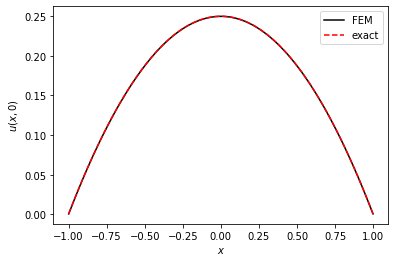

In [11]:
# plot solution at u(x,0)
tol = 0.001 # Avoid hitting the outside of the domain
x = np.linspace(-1 + tol, 1 - tol, 101)
points = np.zeros((3, 101))
points[0] = x
u_values = []
p_values = []

from dolfinx import geometry
bb_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
        
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u.eval(points_on_proc, cells)

plt.plot(x,u_values,'k-')
plt.plot(x,(1-x*x)/4,'r--')
plt.xlabel('$x$')
plt.ylabel('$u(x,0)$')
plt.legend(['FEM','exact'])
plt.show()

# Basic Poisson equation with a time-dependent source term

This example builds on the *basic Poisson equation* example ([click this link](#poissonBasic)). It illustrates how to:

- Efficiently solve a linear partial differential equation multiple times;
- Assign updated values to the `Constant` objects and user-defined classes that are interpolated to the `FunctionSpace`.

## Equation and problem definition

The Poisson equation on a unit disk ($R=1$) with  Dirichlet boundary conditions:

<div align="center">    
    \begin{array}{r c c l}
    \nabla^2 u &=& -f(t) & \text{in } \Omega,\\
    u &=& 0 & \text{on } \Gamma,\\
    \end{array}    
</div>
where $f(t)=t$.

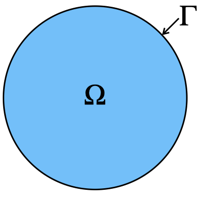

### Weak formulation of the problem

In FEniCS, we are solving the weak form of the PDE
$$\int_\Omega d{\bf x} \ (\nabla^2 u + f(t)) \ v = 0,$$
where $v$ is an arbitrary *test function* that evaluates to $0$ on the boundary points with prescribed values (Dirichlet boundary conditions). Using the integration by parts, the above equation can be rewritten as 
$$\int_\Omega d{\bf x} \ (-\nabla u \cdot \nabla v + f(t) v) = 0.$$

## Implementation

Following the same steps as in the *basic Poisson equation* example ([click this link](#poissonBasic)), we import relevant libraries, generate mesh, define function space, impose the Dirichlet boundary conditions, and define the function $u$ and the test function $v$.

In [12]:
from dolfinx import *
import gmsh
from dolfinx.io import gmshio
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import *
import pyvista
pyvista.start_xvfb()


gmsh.initialize()
R = 1. # radius
meshSize = 0.05 # cell size
gdim = 2 # dimensionality of the system
markerId = 1
disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()
gmsh.model.addPhysicalGroup(gdim, [disk], markerId)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",meshSize)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",meshSize)
gmsh.model.mesh.generate(gdim)
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)
gmsh.finalize()


def plotScalarFunction(u, clim):
    u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(FS)
    u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
    u_grid.point_data["u"] = u.x.array.real
    u_grid.set_active_scalars("u")
    u_plotter = pyvista.Plotter(notebook=True)
    u_plotter.add_mesh(u_grid, clim=clim,show_edges=True)
    u_plotter.view_xy()
    u_plotter.show()


#define function space
degreeElements = 1
FS = fem.FunctionSpace(domain, ('Lagrange', degreeElements))


#impose Dirichlet boundary conditions
# Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
boundary_dofs = fem.locate_dofs_topological(FS, fdim, boundary_facets)

bc = fem.dirichletbc(ScalarType(0), boundary_dofs, FS)

#define function u and test function v
u = fem.Function(FS)
v = TestFunction(FS)

The weak formulation of the problem
$$\int_\Omega d{\bf x} \ (-\nabla u \cdot \nabla v + f(t) v) = 0,$$
where we introduced the time-dependent source term $f(t)$ via the `Constant` object:

In [13]:
# weak formulation of the problem
from petsc4py.PETSc import ScalarType
f = fem.Constant(domain, ScalarType(0.))
Res = -dot(grad(u), grad(v))*dx + f*v*dx
problem = fem.petsc.NonlinearProblem(Res, u, bcs=[bc])
solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)

To solve the problem multiple times, we just need to update the value of the object `f` and we don't need to redefine the residual `Res`. This is because the residual `Res` is linked to the object `f`. Thus it is important that we update the value of the object `f` rather than creating a new object `f`.

In [14]:
cmin=0   #lower limit for the colorbar
cmax=0.5 #upper limit for the colorbar
for t in range(0,3):
    # update the value of the source term
    print(t)
    f.value=t
    solver.solve(u)
    plotScalarFunction(u,[cmin,cmax])

0


VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='101...], sizing_mode='stretch_width')

1


VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='101...], sizing_mode='stretch_width')

2


VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='101...], sizing_mode='stretch_width')

Note that if the source term $f(t,{\bf x})$ also had a spatial dependence, then we can achieve a similar effect with a custom class that is interpolated to the `FunctionSpace`:

In [15]:
class myClass():
    def __init__(self, t, a):
        self.t = t
        self.a = a
    def __call__(self, x):
        return self.t + self.a*x[0];
fObject = myClass(t,0)
f = fem.Function(FS)
f.interpolate(fObject)

Res = -dot(grad(u), grad(v))*dx + f*v*dx
problem = fem.petsc.NonlinearProblem(Res, u, bcs=[bc])
solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)

cmin=0   #lower limit for the colorbar
cmax=0.5 #upper limit for the colorbar
for t in range(0,3):
    # update the value of the source term
    print(t)
    fObject.t=t
    f.interpolate(fObject)
    solver.solve(u)
    plotScalarFunction(u,[cmin,cmax])

0


VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='102...], sizing_mode='stretch_width')

1


VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='102...], sizing_mode='stretch_width')

2


VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='103...], sizing_mode='stretch_width')

# <a name="poissonGeneral"></a>General Poisson equation

This example illustrates how to:

- Solve a linear partial differential equation with Dirichlet and Neumann boundary conditions;
- Define custom expressions and project them on the `FunctionSpace` 
- Calculate the gradient of scalar function and project it on the `VectorFunctionSpace`.

## Equation and problem definition

The general Poisson equation on a unit disk ($R=1$) with the Dirichlet boundary condition on $\Gamma_D$ and the Neumann boundary condition on $\Gamma_N$:

<div align="center">    
    \begin{array}{r c c l}
    \nabla \cdot (a \nabla u) &=& -f & \text{in } \Omega,\\
    u &=& u_D & \text{on } \Gamma_D,\\
    {\bf n} \cdot a \nabla u &=& g & \text{on } \Gamma_N,\\
    \end{array}    
</div>
where $\bf n$ is the unit normal vector to the boundary and we introduced functions
<div align="center">    
    \begin{array}{r c l}
    a &=& 1-\frac{1}{2} (x^2 + y^2),\\
    f &=& 1,\\
    u_D &=& x,\\
    g &=& y,\\
    \end{array}    
</div>

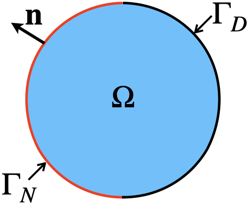

### Weak formulation of the problem

In FEniCS, we are solving the weak form of the PDE
$$\int_\Omega d{\bf x} \ (-\nabla \cdot (a \nabla u) - f) \ v = 0,$$
where $v$ is an arbitrary *test function* that evaluates to $0$ on the boundary points with prescribed values (Dirichlet boundary conditions on $\Gamma_D$). Using integration by parts, the above equation can be rewritten as 
$$\int_\Omega d{\bf x} \ (a \nabla u \cdot \nabla v -  fv) - \oint_\Gamma ds \ ({\bf n} \cdot a \nabla u) v  = \int_\Omega d{\bf x} \ (a \nabla u \cdot \nabla v -  fv) - \oint_\Gamma ds \ g v = 0,$$
where we can integrate over the entire boundary $\Gamma = \Gamma_D \bigcup \Gamma_N$, because $v=0$ on $\Gamma_D$.

> <font color='blue'>The Neumann boundary condition can be recovered naturally from the weak form, and, for that reason, it is also referred to as the *natural boundary condition*. On the other hand, the Dirichlet boundary condition is essential for defining both strong and weak form, and is thus referred to as the *essential boundary condition*.</font>

## Implementation

Following the same steps as in the *basic Poisson equation* example ([click this link](#poissonBasic)), we import relevant libraries, generate mesh, define function space, and define the function $u$ and the test function $v$.

In [16]:
from dolfinx import *
import gmsh
from dolfinx.io import gmshio
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import *
import pyvista
import numpy as np
pyvista.start_xvfb()

gmsh.initialize()
R = 1. # radius
meshSize = 0.05 # cell size
gdim = 2 # dimensionality of the system
markerId = 1
disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()
gmsh.model.addPhysicalGroup(gdim, [disk], markerId)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",meshSize)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",meshSize)
gmsh.model.mesh.generate(gdim)
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)
gmsh.finalize()


def plotScalarFunction(u):
    u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(FS)
    u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
    u_grid.point_data["u"] = u.x.array.real
    u_grid.set_active_scalars("u")
    u_plotter = pyvista.Plotter(notebook=True)
    u_plotter.add_mesh(u_grid,show_edges=True)
    u_plotter.view_xy()
    u_plotter.show()


#define function space
degreeElements = 1
FS = fem.FunctionSpace(domain, ('Lagrange', degreeElements))

#define function u and test function v
u = fem.Function(FS)
v = TestFunction(FS)

To impose Dirichlet boundary conditions ($u_D=x$ on $\Gamma_D$) on the Function Space `FS`, we have to define a function that returns a boolean value: `True` if the given point $\bf x$ lies on the Dirichlet boundary $\Gamma_D$ and `False` otherwise. This is achieved with the function `right_boundary`.

In [17]:
def right_boundary(x):
    return np.logical_and(np.isclose(np.sqrt(x[0]**2 + x[1]**2), R), x[0]>=0)
dofs_D = fem.locate_dofs_geometrical(FS, right_boundary)

uD = fem.Function(FS)
uD.interpolate(lambda x: x[0])
bc = fem.dirichletbc(uD, dofs_D)

To define functions $u_D=x$ and $a=1-\frac{1}{2} (x^2 + y^2)$, we use the anonymouc lambda function, where `x[0]` and `x[1]` refer to the $x$ and $y$ coordinates, respectively, which is then interpolated to the `FunctionSpace` over the whole domain. The source term, $f=1$, has no spatial dependence and can be prescribed as a number. For the function $g=y$ we use an alternative implementation via a custom class, which is then also interpolated to the `FunctionSpace'.

In [18]:
a = fem.Function(FS)
a.interpolate(lambda x: 1-0.5*(x[0]**2+x[1]**2))

f  = 1

class myClass():
    def __call__(self, x):
        return x[1];
gObject = myClass()
g = fem.Function(FS)
g.interpolate(gObject)

The weak formulation of the problem
$$\int_\Omega d{\bf x} \ (a \nabla u \cdot \nabla v -  fv) - \oint_\Gamma ds \ g v = 0,$$
where `dx` describes the integration over the domain $\Omega$  and `ds` describes the integration over the boundary $\Gamma = \Gamma_D \bigcup \Gamma_N$. Note that we can integrate over the entire boundary, because $v=0$ on $\Gamma_D$.

In [19]:
# weak formulation of the problem
Res = a*dot(grad(u), grad(v))*dx - f*v*dx - g*v*ds
problem = fem.petsc.NonlinearProblem(Res, u, bcs=[bc])
solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)

Next, we solve the problem and plot the solution $u({\bf x})$.

In [20]:
# solve the problem
solver.solve(u)

# plot solution
plotScalarFunction(u)

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='103...], sizing_mode='stretch_width')

To calculate the function ${\boldsymbol \sigma}=a \nabla u$, we *project* the expression `a*grad(u)` on the `VectorFunctionSpace`. When creating a `VectorFunctionSpace` in FEniCSx, the dimension will be set equal to the geometric
dimension of the finite element mesh. To specify a vector function space with other dimensions one can use the parameter dim, e.g. `V = VectorFunctionSpace(mesh, ('Lagrange', 1), dim=10)` creates a 10 dimensional vector function space with linear Lagrange elements.

In [21]:
degreeElements = 1
VFS = fem.VectorFunctionSpace(domain, ('Lagrange', degreeElements))
sigma_expr = fem.Expression(a*grad(u), VFS.element.interpolation_points())
sigma = fem.Function(VFS)
sigma.interpolate(sigma_expr)


def plotVectorFunction(sigma):
  topology, cell_types, geometry = plot.create_vtk_mesh(VFS)
  values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
  values[:, :len(sigma)] = sigma.x.array.real.reshape((geometry.shape[0], len(sigma)))

  # Create a point cloud of glyphs
  function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
  function_grid["sigma"] = values
  glyphs = function_grid.glyph(orient="sigma", factor=0.1)

  # Create a pyvista-grid for the mesh
  grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(domain, domain.topology.dim))

  # Create plotter
  plotter = pyvista.Plotter(notebook=True)
  plotter.add_mesh(grid, style="wireframe", color="k")
  plotter.add_mesh(glyphs)
  plotter.view_xy()
  plotter.show()

plotVectorFunction(sigma)

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='103...], sizing_mode='stretch_width')

# Mixed formulation for the general Poisson equation

This example is an alternative implementation of the *general Poisson equation* example ([click this link](#poissonGeneral)). It illustrates how to:

- Solve coupled partial differential equations using `MixedElement`;
- Split the (test)function into (test)functions that correspond to subspaces of the mixed element function space;
- Impose Dirichlet boundary conditions on a subspace of the function space.

## Equation and problem definition

The mixed formulation of the general Poisson equation on a unit disk ($R=1$) with the Dirichlet boundary condition on $\Gamma_D$ and the Neumann boundary condition on $\Gamma_N$:

<div align="center">    
    \begin{array}{r c c l}
    \nabla \cdot {\boldsymbol \sigma}  &=& -f & \text{in } \Omega,\\
    {\boldsymbol \sigma} &=& a \nabla u & \text{in } \Omega,\\
    u &=& u_D & \text{on } \Gamma_D,\\
    {\bf n} \cdot {\boldsymbol \sigma} &=& g & \text{on } \Gamma_N,\\
    \end{array}    
</div>
where $\bf n$ is the unit normal vector to the boundary and we introduced functions
<div align="center">    
    \begin{array}{r c l}
    a &=& 1-\frac{1}{2} (x^2 + y^2),\\
    f &=& 1,\\
    u_D &=& x,\\
    g &=& y.\\
    \end{array}    
</div>

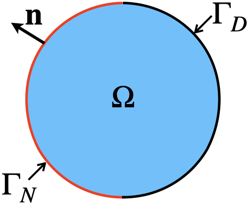

### Weak formulation of the problem

In FEniCSx, we are solving the weak form of coupled PDEs
<div align="center">    
    \begin{array}{l l}
    \int_\Omega d{\bf x} \ (-\nabla \cdot {\boldsymbol \sigma} -f) v = 0 & \text{in } \Omega,\\
    \int_\Omega d{\bf x} \ ({\boldsymbol \sigma} - a \nabla u) \cdot {\boldsymbol \tau}=0  & \text{in } \Omega,\\
    \end{array}    
</div>

where $v$ and ${\boldsymbol \tau}$ are arbitrary *test functions*. Here, we assume that the boundary condition $u = u_D$ on $\Gamma_D$ is the *essential condition* and that the boundary condition ${\bf n} \cdot {\boldsymbol \sigma} = g$ on $\Gamma_N$ is the *natural condition*, which can be extracted from the weak form. Thus we impose the restriction $v=0$ on $\Gamma_D$, but there is no such restriction on ${\boldsymbol \tau}$. Using integration by parts, the first equation can be rewritten as 
$$\int_\Omega d{\bf x} \ ({\boldsymbol \sigma} \cdot \nabla v -  fv) - \oint_\Gamma ds \ ({\bf n} \cdot {\boldsymbol \sigma}) v  = \int_\Omega d{\bf x} \ ({\boldsymbol \sigma} \cdot \nabla v -  fv) - \oint_\Gamma ds \ g v = 0,$$
where we can integrate over the entire boundary $\Gamma = \Gamma_D \bigcup \Gamma_N$, because $v=0$ on $\Gamma_D$.

> <font color='blue'>Note that it is possible to switch the essential and natural boundary conditions, which is discussed in the <a href="https://fenicsproject.org/olddocs/dolfin/1.6.0/python/demo/documented/mixed-poisson/python/documentation.html" target="_blank">FEniCS demo</a>.
</font>

## Implementation

We import relevant libraries and generate mesh as was done in the *basic Poisson equation* example ([click this link](#poissonBasic)).

In [22]:
from dolfinx import *
import gmsh
from dolfinx.io import gmshio
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import *
import pyvista
import numpy as np
pyvista.start_xvfb()

gmsh.initialize()
R = 1. # radius
meshSize = 0.05 # cell size
gdim = 2 # dimensionality of the system
markerId = 1
disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()
gmsh.model.addPhysicalGroup(gdim, [disk], markerId)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",meshSize)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",meshSize)
gmsh.model.mesh.generate(gdim)
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)
gmsh.finalize()

We use `MixedElement` to define the combined function space for both $u$ (scalar) and ${\boldsymbol \sigma}$ (vector). First we define `FiniteElement`s that will be used (linear  Lagrange elements). Because ${\boldsymbol \sigma}$ is a 2D vector field we create `VectorElement's.

In [23]:
#define function space with mixed finite elements
degreeElements = 1
FE_u     = FiniteElement("Lagrange", domain.ufl_cell(), degreeElements)
FE_sigma = VectorElement("Lagrange", domain.ufl_cell(), degreeElements, dim=2)
MFS = fem.FunctionSpace(domain, MixedElement([FE_u, FE_sigma]))

The (test)functions on this `FunctionSpace` can be defined as usual. However, it is convenient to `split` these (test)functions into (test)functions that correspond to subspaces.

In [24]:
# define function and split it into u and sigma
mixedFunction  = fem.Function(MFS) 
u,sigma = split(mixedFunction)

# define test function and split it into v and tau
tf = TestFunction(MFS)
v,tau = split(tf)

The functions $a$, $f$, and $g$ are implemented in the same way as was done in the *general Poisson equation* example ([click this link](#poissonGeneral)).

In [25]:
degreeElements = 1
FS = fem.FunctionSpace(domain, ('Lagrange', degreeElements))
a = fem.Function(FS)
a.interpolate(lambda x: 1-0.5*(x[0]**2+x[1]**2))

f  = 1

class myClass():
    def __call__(self, x):
        return x[1];
gObject = myClass()
g = fem.Function(FS)
g.interpolate(gObject)

The Dirichlet boundary condition $u=u_D=x$ on $\Gamma_D$ has to be imposed only on the subspace of the entire function space, which can be achieved with `.sub(0)`

In [26]:
#impose Dirichlet boundary conditions for u
V0, dofs0 = MFS.sub(0).collapse()
def right_boundary(x):
    return np.logical_and(np.isclose(np.sqrt(x[0]**2 + x[1]**2), R), x[0]>=0)
boundary_facets = mesh.locate_entities_boundary(domain, domain.topology.dim-1, right_boundary)
dofs_D = fem.locate_dofs_topological((MFS.sub(0),V0), domain.topology.dim-1, boundary_facets)

uD = fem.Function(V0)
uD.interpolate(lambda x: x[0])
bc = fem.dirichletbc(uD, dofs_D,  MFS.sub(0))

Next, we write and solve the weak form of the problem. 
<div align="center">    
    \begin{array}{l l}
    \int_\Omega d{\bf x} \ ({\boldsymbol \sigma} \cdot \nabla v -  fv) - \oint_\Gamma ds \ g v = 0,\\
    \int_\Omega d{\bf x} \ ({\boldsymbol \sigma} - a \nabla u) \cdot {\boldsymbol \tau}=0,\\
    \end{array}    
</div>

In [27]:
#weak formulation of the problem
Res_1 = (dot(sigma,grad(v)) - f*v)*dx - v*g*ds
Res_2 = (dot(sigma, tau) - dot(a*grad(u), tau))*dx
Res   = Res_1 + Res_2

# solve the problem and store solution in F
problem = fem.petsc.NonlinearProblem(Res, mixedFunction, bcs=[bc])
solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.solve(mixedFunction)

(1, True)

When ploting the solutions $u$ and ${\boldsymbol \sigma}=a \nabla u$, we have to be careful to use appropriate subspaces.

In [28]:
# plot scalar function u
V0, dofs0 = MFS.sub(0).collapse()
c_topology, c_cell_types, c_geometry = plot.create_vtk_mesh(V0)
c_grid = pyvista.UnstructuredGrid(c_topology, c_cell_types, c_geometry)
c_grid.point_data["c"] = mixedFunction.x.array[dofs0].real
c_grid.set_active_scalars("c")
u_plotter = pyvista.Plotter(notebook=True)
u_plotter.add_mesh(c_grid,show_edges=True)
u_plotter.view_xy()
u_plotter.show()


# plot vector function sigma
V1, dofs1 = MFS.sub(1).collapse()
topology, cell_types, geometry = plot.create_vtk_mesh(V1)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(sigma)] = mixedFunction.x.array[dofs1].real.reshape((geometry.shape[0], len(sigma)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["sigma"] = values
glyphs = function_grid.glyph(orient="sigma", factor=0.1)

# Create a pyvista-grid for the mesh
grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(domain, domain.topology.dim))

# Create plotter
plotter = pyvista.Plotter(notebook=True)
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
plotter.show()

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='104...], sizing_mode='stretch_width')

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='104...], sizing_mode='stretch_width')

# General Poisson equation as the minimization problem

This example is an alternative implementation of the *general Poisson equation* example ([click this link](#poissonGeneral)). It illustrates how to:

- Minimize functionals.

## Equation and problem definition

Consider a functional 
$$E[u] = \int_\Omega d{\bf x} \left[\frac{1}{2} a (\nabla u)^2 - f u \right] - \int_{\Gamma} ds \ g u,$$
with prescribed values $u=u_D$ on $\Gamma_D \subset \Gamma$, where
<div align="center">    
    \begin{array}{r c l}
    a &=& 1-\frac{1}{2} (x^2 + y^2),\\
    f &=& 1,\\
    u_D &=& x,\\
    g &=& y.\\
    \end{array}    
</div>

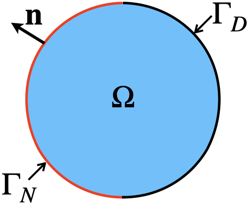

A small variation of the function $u+\delta u$ with $\delta u=0$ on $\Gamma_D$ results in the variation of the functional $E[u+\delta u] = E[u]+\delta E$ where 
$$\delta E = \int_\Omega d{\bf x} \left[a \nabla u \cdot \nabla \delta u - f \delta u \right] - \int_{\Gamma} ds \ g \delta u.$$

We are searching for the function $u$ that minimizes the functional $E[u]$. In this case, the variation $\delta E$ has to vanish
<div align="center">    
    \begin{array}{r c l}
 0 & =&  \int_\Omega d{\bf x} \left[a \nabla u \cdot \nabla \delta u - f \delta u \right] - \int_{\Gamma} ds \ g \delta u,\\
 0 & =&  \int_\Omega d{\bf x} \left[- \nabla \cdot (a \nabla u) - f \right]  \delta u + \int_{\Gamma} ds \ ({\bf n} \cdot a \nabla u -g) \delta u, 
 \end{array}   
</div>
where $\bf n$ is the unit normal vector to the boundary and we used the integration by parts in the second line. Since the variation $\delta u$ is arbitrary, the function $u$ that minimizes the functional $E[u]$ has to satisfy the equations 
<div align="center">    
    \begin{array}{r c c l}
    \nabla \cdot (a \nabla u) &=& -f & \text{in } \Omega,\\
   u &=& u_D & \text{on } \Gamma_D,\\
   {\bf n} \cdot a \nabla u &=& g & \text{on } \Gamma_N.\\
    \end{array}    
</div>

These equations are identical to the ones discussed in the *general Poisson equation* example ([click this link](#poissonGeneral)).

> <font color='blue'>Note: The variation $\delta u$ plays a similar role as the test function $v$ in the weak formulation of the general Poisson equation.
</font>

## Implementation

Following the same steps as in the *general Poisson equation* example ([click this link](#poissonGeneral)), we import relevant libraries, generate mesh, define function space, the function $u$, the test function $v$, and the functions $a$, $f$, and $g$, and impose Dirichlet boundary conditions $u=u_D$.

In [29]:
from dolfinx import *
import gmsh
from dolfinx.io import gmshio
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import *
import pyvista
import numpy as np
pyvista.start_xvfb()

gmsh.initialize()
R = 1. # radius
meshSize = 0.05 # cell size
gdim = 2 # dimensionality of the system
markerId = 1
disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()
gmsh.model.addPhysicalGroup(gdim, [disk], markerId)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",meshSize)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",meshSize)
gmsh.model.mesh.generate(gdim)
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)
gmsh.finalize()


def plotScalarFunction(u):
    u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(FS)
    u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
    u_grid.point_data["u"] = u.x.array.real
    u_grid.set_active_scalars("u")
    u_plotter = pyvista.Plotter(notebook=True)
    u_plotter.add_mesh(u_grid,show_edges=True)
    u_plotter.view_xy()
    u_plotter.show()

def plotVectorFunction(sigma):
  topology, cell_types, geometry = plot.create_vtk_mesh(VFS)
  values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
  values[:, :len(sigma)] = sigma.x.array.real.reshape((geometry.shape[0], len(sigma)))
  # Create a point cloud of glyphs
  function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
  function_grid["sigma"] = values
  glyphs = function_grid.glyph(orient="sigma", factor=0.1)
  # Create a pyvista-grid for the mesh
  grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(domain, domain.topology.dim))
  # Create plotter
  plotter = pyvista.Plotter(notebook=True)
  plotter.add_mesh(grid, style="wireframe", color="k")
  plotter.add_mesh(glyphs)
  plotter.view_xy()
  plotter.show()


#define function space
degreeElements = 1
FS = fem.FunctionSpace(domain, ('Lagrange', degreeElements))

#define function u and test function v
u = fem.Function(FS)
v = TestFunction(FS)

def right_boundary(x):
    return np.logical_and(np.isclose(np.sqrt(x[0]**2 + x[1]**2), R), x[0]>=0)
dofs_D = fem.locate_dofs_geometrical(FS, right_boundary)

uD = fem.Function(FS)
uD.interpolate(lambda x: x[0])
bc = fem.dirichletbc(uD, dofs_D)



a = fem.Function(FS)
a.interpolate(lambda x: 1-0.5*(x[0]**2+x[1]**2))

f  = 1

class myClass():
    def __call__(self, x):
        return x[1];
gObject = myClass()
g = fem.Function(FS)
g.interpolate(gObject)

Next we define the energy functional
$$E[u] = \int_\Omega d{\bf x} \left[\frac{1}{2} a (\nabla u)^2 - f u \right] - \int_{\Gamma} ds \ g u.$$

In [30]:
# functional
E = (1/2*a*dot(grad(u),grad(u))-f*u)*dx - g*u*ds

Here `dx` describes the integration over the domain $\Omega$  and `ds` describes the integration over the boundary $\Gamma = \Gamma_D \bigcup \Gamma_N$. Note that we integrated over the entire boundary, because we will use the fact that the variation $\delta u=v=0$ on $\Gamma_D$.

To calculate the variation $\delta E$, we use the `derivate` function, where the first argument is the functional $E[u]$, the second argument is the function $u$, and the third argument is the variation $v=\delta u$. Note that here we use the arbitrary *test function* $v$ in the third argument, which is used by FEniCS to solve the minimization problem.

In [31]:
# solve the problem
Res = derivative(E, u, v)
problem = fem.petsc.NonlinearProblem(Res, u, bcs=[bc])
solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.solve(u)

# plot solution
plotScalarFunction(u)

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='105...], sizing_mode='stretch_width')

We plot the solution $u$ and calculate  ${\boldsymbol \sigma}=a \nabla u$ and $\nabla \cdot {\boldsymbol \sigma}=\nabla \cdot (a \nabla u)$
as was done in the *general Poisson equation* example ([click this link](#poissonGeneral)).

In [32]:
degreeElements = 1
VFS = fem.VectorFunctionSpace(domain, ('Lagrange', degreeElements))
sigma_expr = fem.Expression(a*grad(u), VFS.element.interpolation_points())
sigma = fem.Function(VFS)
sigma.interpolate(sigma_expr)

plotVectorFunction(sigma)

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='105...], sizing_mode='stretch_width')

# Linear deformation of elastic material with a circular hole using clamped-free boundary conditions

This example illustrates how to:

- Subtract domains, when generating meshes;
- Use tensors and tensor operations;
- Impose Dirichlet boundary conditions on subspaces of the function space;
- Export solution into an XDMF file for visualization in <a href="https://www.paraview.org/" target="_blank">ParaView</a>.

## Equation and problem definition

We consider linear deformation of a 2D elastic material with a circular hole by imposing clamped boundary conditions on the left ($\Gamma_l$) and right ($\Gamma_r$) boundaries  and traction-free boundary conditions (i.e., free from external loads) on all other boundaries ($\Gamma_t$, $\Gamma_b$, $\Gamma_h$).

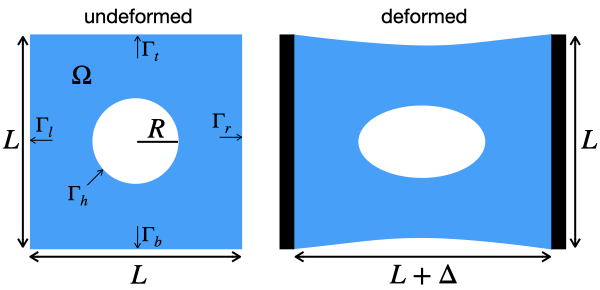

Linear deformation of the elastic material can be obtained by solving the force-balance equation
$$\partial_j \sigma_{ij}  = 0  \text{   in   } \Omega,$$
where $\sigma_{ij}$ is the stress tensor, where $i,j\in\{x,y\}$ and the summation over repeated indices is implied. The constitutive equations for a linear elastic material are 
$$\sigma_{ij} = 2 \mu \epsilon_{ij} + \lambda \epsilon_{kk} \delta_{ij},$$
where $\lambda$ and $\mu$ are 2D Lamé constants that can be expressed in terms of the 2D Young's modulus $E$ and the Poisson's ratio $\nu$ as $\mu=E/[2(1+\nu)]$ and $\lambda = E \nu/(1-\nu^2)$. In this example, we use $E=1$ and $\nu=0.4$. We also introduced the strain tensor
$$\epsilon_{ij} = \frac{1}{2} \left(\partial_i u_j + \partial_j u_i\right),$$
where $u_i$ are compontents of displacements $\bf u$.

The left and right boundaries are clamped, i.e., this is where we prescribe displacements. In this example, we have $u_x^D = -\Delta/2$ and $u_y^D=0$ on the left boundary ($\Gamma_l$) and $u_x^D = +\Delta/2$ and $u_y^D=0$ on the right boundary ($\Gamma_r$). Here we use $\Delta=0.2 L$ to exaggerate the deformation. All other boundaries ($\Gamma_t$, $\Gamma_b$, $\Gamma_h$) are traction-free with $\sigma_{ij} n_j = 0$, where $n_j$ is the unit normal vector to the boundary. 

### Energy minimization formulation of the problem

Rather than solving the PDE equations described in the previous section we reformulate the problem as the minimization of the elastic energy
$$E_{el}[u_i]=\int_\Omega d{\bf x} \  \frac{1}{2} \sigma_{ij} \epsilon_{ij},$$
with prescribed displacements on the clamped boundaries.

## Implementation

Before we can use FEniCS we need to import relevant modules.

In [33]:
from dolfinx import *
import gmsh
from dolfinx.io import gmshio
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import *
import pyvista
pyvista.start_xvfb()

To define a rectangular domain with a circular hole we subtract the two domains and generate a triangular mesh.

In [34]:
# Create rectangular mesh with circular hole
L = 1
R = 0.2
gdim = 2
meshSize = 0.02 # mesh resolution

gmsh.initialize()
markerId = 1
outerBox = gmsh.model.occ.addRectangle(-L/2, -L/2, 0, L, L,0)
innerHole = gmsh.model.occ.addDisk(0, 0, 0, R, R)
membrane = gmsh.model.occ.cut([(2, outerBox)], [(2, innerHole)])
gmsh.model.occ.synchronize()
volumes = gmsh.model.getEntities(dim=2)
assert(volumes == membrane[0])
membrane_marker = 11
gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], membrane_marker)

gmsh.option.setNumber("Mesh.CharacteristicLengthMin",meshSize)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",meshSize)
gmsh.model.mesh.generate(gdim)
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)
gmsh.finalize()

print(pyvista.global_theme.jupyter_backend)
tdim = domain.topology.dim
topology, cell_types, geometry = plot.create_vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter = pyvista.Plotter(notebook=True)
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()

panel


VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, sizing_mode='stretch_width')

Define elastic constants and the displacements of the two clamped ends

In [35]:
# elastic constants
E = 1
nu = 0.4
mu = E/2/(1+nu)
Lambda = E*nu/(1-nu*nu)

# displacement of the clamped ends
Delta = 0.2*L

Define the vector function space, the function for displacements ${\bf u}\equiv (u_x, u_y)$ and the test function $\bf v$.

In [36]:
#define vector function space, function u, and test function v
degreeElements = 1
VFS = fem.VectorFunctionSpace(domain, ('Lagrange', degreeElements))
u  = fem.Function(VFS)
v  = TestFunction(VFS)

To impose the Dirichlet boundary conditions for displacements of clamped boundaries, we need to define functions `left_boundary` and `right_boundary` that return `True` for points that are on the left and right boundaries, respectively. Constant displacement vectors $(u_x,u_y)$ on these boundaries are prescribed with the `ScalarType` function.

In [37]:
#impose clamped boundary conditions
def left_boundary(x):
    return np.isclose(x[0],-L/2);
def right_boundary(x):
    return np.isclose(x[0],+L/2);

fdim = domain.topology.dim - 1
boundary_facets_left = mesh.locate_entities_boundary(domain, fdim, left_boundary)
dofs_left = fem.locate_dofs_topological(VFS, fdim, boundary_facets_left)
u_left = ScalarType((-Delta/2, 0))
bc_left = fem.dirichletbc(u_left, dofs_left, VFS)

boundary_facets_right = mesh.locate_entities_boundary(domain, fdim, right_boundary)
dofs_right = fem.locate_dofs_topological(VFS, fdim, boundary_facets_right)
u_right = ScalarType((+Delta/2, 0))
bc_right = fem.dirichletbc(u_right, dofs_right, VFS)

bc = [bc_left, bc_right]

We define the strain tensor $\epsilon_{ij} = \frac{1}{2} \left(\partial_i u_j + \partial_j u_i\right)$ as `sym(grad(u))`, where the `sym` function returns $sym(M_{ij})=\frac{1}{2} (M_{ij}+M_{ji})$ and the `grad(u)` expression results in $\partial_i u_j$. We also define the constitutive equations $\sigma_{ij} = 2 \mu \epsilon_{ij} + \lambda \epsilon_{kk} \delta_{ij}$.

In [38]:
tdim=domain.topology.dim
# define strain and stress
def epsilon(u):
    return sym(grad(u))
def sigma(u):
    return 2*mu*epsilon(u) + Lambda*tr(epsilon(u))*Identity(tdim)

To calculate the elastic energy $E_{el}[u_i]=\int_\Omega  d{\bf x} \  \frac{1}{2} \sigma_{ij} \epsilon_{ij}$ we use the inner product of tensors. Then we minimize the elastic energy and impose Dirichlet boundary conditions on the two clamped ends.

In [39]:
# elastic energy
Energy = 1/2*inner(sigma(u),epsilon(u))*dx

# minimize elastic energy
Res = derivative(Energy, u, v)
# solve the problem
problem = fem.petsc.NonlinearProblem(Res, u, bcs=bc)
solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.solve(u)

(1, True)

To evaluate the value of the elastic energy, we can use the `assemble_scalar` function

In [40]:
# calculate elastic energy
print("Energy = ", fem.assemble_scalar(fem.form(Energy)))

Energy =  0.014412390517361618


In mechanics, it is common to analyze stresses by visualization of the <a href="https://en.wikipedia.org/wiki/Von_Mises_yield_criterion" target="_blank">von Mises stress</a>, which is defined as 
$\sigma_\text{vM} = \sqrt{(3/2) \hat \sigma_{ij} \hat \sigma_{ij}}$, where $\hat \sigma_{ij}=\sigma_{ij}-(1/d) \sigma_{kk} \delta_{ij}$ is the deviatoric stress.

In [41]:
# calculate and export von Mises stress
V_von_mises = fem.FunctionSpace(domain, ('Lagrange', 1))
devStress = sigma(u) - (1./tdim)*tr(sigma(u))*Identity(tdim)  # deviatoric stress
von_Mises = sqrt(3./2*inner(devStress, devStress))
stress_expr = fem.Expression(von_Mises, V_von_mises.element.interpolation_points())
stresses = fem.Function(V_von_mises)
stresses.interpolate(stress_expr)

We can export displacements $\bf u$ and von Mises stress $\sigma_\text{vM}$ to a XDMF file for visualization in <a href="https://www.paraview.org/" target="_blank">ParaView</a>. We rename the value of function $u$, such that it will have a meaningful name in ParaView.

In [42]:
xdmf = io.XDMFFile(domain.comm, "clamped_deformation.xdmf", "w")
xdmf.write_mesh(domain)
u.name = "displacements"
xdmf.write_function(u)
stresses.name = "von Mises"
xdmf.write_function(stresses)
xdmf.close()

# Cahn-Hilliard equation

This example illustrates how to:

- Solve time evolution of non-linear PDEs;
- Implement initial conditions with small random perturbation.

Note that this example is based on the FEniCS demo: <a href="https://docs.fenicsproject.org/dolfinx/v0.6.0/python/demos/demo_cahn-hilliard.html" target="_blank">click here</a>.

## Equation and problem definition

The <a href="https://en.wikipedia.org/wiki/Cahn%E2%80%93Hilliard_equation" target="_blank">Cahn-Hilliard equation</a> describes the process of phase separation, by which the two components of a binary fluid spontaneously separate and form domains enriched in one of the two components. The driving force for the phase separation is the tendency of the system to lower the total free energy
$$G[c] = \int_\Omega d{\bf x}\, \left[f(c) + \frac{1}{2}\lambda (\nabla c)^2\right],$$
where $c$ is an order parameter and the two phases correspond to $c=0$ and $c=1$. The first term in the above equation describes the bulk free energy and the second term the interfacial energy between the two phases. The bulk free energy density is commonly described with the double well potential and in this example we use the free energy density $f(c)=100 c^2 (1-c)^2$.

To describe the kinetics of the phase separation process it is convenient to first introduce the chemical potential $\mu$, which can be obtained as the functional derivative of the free energy. More precisely, we calculate the variation of the free energy $G[c+\delta c]=G[c]+\delta G$, where the variation is
$$\delta G= \int_\Omega d{\bf x} \ \left[f'(c) \delta c + \lambda \nabla c \cdot \nabla \delta c\right]=\int_\Omega d{\bf x}\  \left[f'(c) - \lambda (\nabla^2 c) \right] \delta c \equiv \int_\Omega  d{\bf x}\ \mu \delta c,$$
where we used integration by parts and defined the chemical potential
$$\mu = f'(c) - \lambda \nabla^2 c.$$
The gradients of the chemical potential provide the driving force for the redistribution of material, and this kinetics is described with
$$\frac{\partial c}{\partial t} = \nabla \cdot (M \nabla \mu),$$
where $M$ is the mobility.

### Discretizaton of time 

In order to solve the two coupled PDEs for the concentration $c({\bf x},t)$ and chemical potential $\mu({\bf x},t)$, we first discuss the time discretization. Fields are evaluated at discrete timesteps $t_n = n \Delta t$, where $n=0,1,2,\ldots$. We use the notation $c_{n}({\bf x})\equiv c({\bf x},t_n)$ and $\mu_{n}({\bf x})\equiv \mu({\bf x},t_n)$. The two coupled PDEs can then be written as 
    \begin{aligned}
    \frac{c_{n+1}-c_{n}}{\Delta t} &= \nabla \cdot (M \nabla \mu_{n+\theta}),\\
    \mu_{n+1} &= f'(c_{n+1}) - \lambda \nabla^2 c_{n+1},\\
    \end{aligned}   
where $\mu_{n+\theta} = (1-\theta) \mu_{n} + \theta \mu_{n+1}$. Different choices for the parameter $\theta$ correspond to the forward Euler method ($\theta=0$), the backward Euler method ($\theta=1$), and the Crank–Nicolson method ($\theta=1/2$). Check the <a href="https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method" target="_blank">Wikipedia article</a> for more information about the differences between these three methods. In this example we use the Crank–Nicolson method ($\theta=1/2$). The general procedure is to start with the initial concentrations $c_0({\bf x})$, from which we can calculate the chemical potentials $\mu_0({\bf x})$ at time 0. Then we iteratively calculate the fields ($c_{n+1}$, $\mu_{n+1}$) at time $t_{n+1}$ from the values of fields ($c_{n+1}$, $\mu_{n+1}$) at time $t_n$.

### Weak formulation of the problem

The final step is to write the weak formulation of the coupled PDEs
    \begin{aligned}\int_\Omega d{\bf x} \
    \left[\frac{c_{n+1}-c_{n}}{\Delta t} - \nabla \cdot (M \nabla \mu_{n+\theta})\right] q & = 0,\\
    \int_\Omega d{\bf x} \ \left[\mu_{n+1} - f'(c_{n+1}) + \lambda \nabla^2 c_{n+1}\right] v & = 0,\\
    \end{aligned}
where we introduced two *test functions* $q$ and $v$. After the integration by parts the two coupled PDEs can be rewritten as
    \begin{aligned}\int_\Omega d{\bf x} \
    \left[\frac{c_{n+1}-c_{n}}{\Delta t} q + M \nabla \mu_{n+\theta} \cdot \nabla q\right]  & = 0,\\
    \int_\Omega d{\bf x} \ \left[\mu_{n+1} v  - f'(c_{n+1})v  - \lambda \nabla c_{n+1} \cdot \nabla v\right] & = 0.\\
    \end{aligned}
In these example, we solve the Cahn-Hilliard equation on a unit square domain with periodic boundary conditions. The intial concentration values are chosen randomly on the interval $(0.62,0.64)$. Other values are chosen as in the <a href="https://docs.fenicsproject.org/dolfinx/v0.6.0/python/demos/demo_cahn-hilliard.html" target="_blank">FEniCS demo</a>, i.e. $\lambda = 10^{-2}$ and $\Delta t = 5 \times 10^{-6}$.

## Implementation

As usual, in order to use solve this problem we need to import all necessary modules.

In [43]:
from dolfinx import *
import gmsh
from dolfinx.io import gmshio
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import *
import pyvista
pyvista.start_xvfb()

Next, we create a mesh for a unit square domain and define the function space, where we use quadrilateral elements. Here we use mixed elements, where the first ellement corresponds to the concentration field $c$ and the second element to the chemical potential field $\mu$. 

In [44]:
# Create mesh and define function space with periodic boundary conditions
domain = mesh.create_unit_square(MPI.COMM_WORLD, 100, 100, mesh.CellType.quadrilateral)
P = FiniteElement('Lagrange', domain.ufl_cell(), 1)
MFS = fem.FunctionSpace(domain, MixedElement([P,P]))

We define functions ${\bf u}_{new}$ and ${\bf u}_{old}$, where we store fields $(c_{n+1},\mu_{n+1})$ and $(c_{n},\mu_{n})$, respectively. We also split the function into the concentration and chemical potential fields. In a similar way we introduce the test function, which is split into two test functions $q$ and $v$.

In [45]:
# Define functions
u_new = fem.Function(MFS)  # solution for the next step
u_old  = fem.Function(MFS)  # solution from previous step
# Split mixed functions
c_new, mu_new  = split(u_new)
c_old, mu_old = split(u_old)

# Define test functions
tf = TestFunction(MFS)
q, v  = split(tf)

To prescribe intitial conditions with the concentration values that are chosen randomly from the interval $(0.62,0.64)$ we implement the anonymous lambda function and interpolate it on the appropriate subspace. In the constructor `(__init__)`, the random number generator is seeded.

In [46]:
# Interpolate initial condition
u_new.x.array[:] = 0.0
u_new.sub(0).interpolate(lambda x: 0.63 + 0.02 * (0.5 - np.random.rand(x.shape[1])))
u_new.x.scatter_forward()

To calculate the contribution $f'(c)$ for the chemical potential we use automated differentiation. The first line declares that $c$ is a variable that some function can be differentiated with respect to. The next line is the function $f=100 c^2 (1-c)^2$ defined in the problem statement, and the third line performs the differentiation of $f$ with respect to the variable $c$.

In [47]:
# Compute the chemical potential df/dc
c_new = variable(c_new)
f    = 100*c_new**2*(1-c_new)**2
dfdc = diff(f, c_new)

Next we implement the weak form of coupled PDEs
    \begin{aligned}\int_\Omega d{\bf x} \
    \left[\frac{c_{n+1}-c_{n}}{\Delta t} q + M \nabla \mu_{n+\theta} \cdot \nabla q\right]  & = 0,\\
    \int_\Omega d{\bf x} \ \left[\mu_{n+1} v  - f'(c_{n+1})v  - \lambda \nabla c_{n+1} \cdot \nabla v\right] & = 0.\\
    \end{aligned}

In [48]:
lmbda  = 1.0e-02  # surface parameter
dt     = 5.0e-06  # time step
theta  = 0.5      # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson

# mu_(n+theta)
mu_mid = (1.0-theta)*mu_old + theta*mu_new

# Weak statement of the equations
Res_0 = (c_new - c_old)/dt*q*dx + dot(grad(mu_mid), grad(q))*dx
Res_1 = mu_new*v*dx - dfdc*v*dx - lmbda*dot(grad(c_new), grad(v))*dx
Res = Res_0 + Res_1

problem = fem.petsc.NonlinearProblem(Res, u_new)
solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)

Prepare files, where we will store concentration and chemical potential fields for the visualization in <a href="https://www.paraview.org/" target="_blank">ParaView</a>.


In [49]:
file = io.XDMFFile(MPI.COMM_WORLD, "ch_output.xdmf", "w")
file.write_mesh(domain)
u_new.sub(0).name = "concentrations"
u_new.sub(1).name = "chemical potential"

Iteratively solve the coupled PDEs for 50 time steps. At each step we first copy the values of fields from the ${\bf u}_{new}$ function to the ${\bf u}_{old}$ function. Then we solve the coupled PDEs and store the new values of fields in the function ${\bf u}_{new}$. Finally, we save the values of fields for visualization in <a href="https://www.paraview.org/" target="_blank">ParaView</a> 

In [50]:
# Step in time
t = 0.0
T = 50*dt
file.write_function(u_new.sub(0), t)
file.write_function(u_new.sub(1), t)
while (t < T):
    t += dt
    print(t)
    u_old.x.array[:] = u_new.x.array
    solver.solve(u_new)
    file.write_function(u_new.sub(0), t)
    file.write_function(u_new.sub(1), t)
file.close()

5e-06
1e-05
1.5000000000000002e-05
2e-05
2.5e-05
3e-05
3.5000000000000004e-05
4e-05
4.5e-05
5e-05
5.5e-05
6e-05
6.500000000000001e-05
7.000000000000001e-05
7.500000000000001e-05
8e-05
8.5e-05
9e-05
9.5e-05
0.0001
0.000105
0.00011
0.000115
0.00012
0.000125
0.00013000000000000002
0.00013500000000000003
0.00014000000000000004
0.00014500000000000006
0.00015000000000000007
0.00015500000000000008
0.0001600000000000001
0.0001650000000000001
0.00017000000000000012
0.00017500000000000013
0.00018000000000000015
0.00018500000000000016
0.00019000000000000017
0.00019500000000000019
0.0002000000000000002
0.0002050000000000002
0.00021000000000000023
0.00021500000000000024
0.00022000000000000025
0.00022500000000000026
0.00023000000000000028
0.0002350000000000003
0.0002400000000000003
0.0002450000000000003
0.00025000000000000033
